In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, ttest_ind

In [2]:
df = pd.read_csv("cleaned_chip_data.csv")

In [3]:
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget,150.0,Kettle


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.to_period('M').astype(str)

#### Define Pre-Trial & Trial Periods

In [5]:
# Trial period: Feb 2019 to April 2019
trial_period = ['2019-02', '2019-03', '2019-04']
pre_trial_period = ['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01']

#### Aggregate Monthly Data

In [6]:
monthly_data = df.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    n_customers=('LYLTY_CARD_NBR', 'nunique'),
    transactions=('TXN_ID', 'nunique')
).reset_index()

monthly_data['avg_txn_per_cust'] = monthly_data['transactions'] / monthly_data['n_customers']

In [7]:
monthly_data

,STORE_NBR,MONTH,total_sales,n_customers,transactions,avg_txn_per_cust
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739
...,...,...,...,...,...,...
3164,272,2019-02,395.5,45,48,1.066667
3165,272,2019-03,442.3,50,53,1.060000
3166,272,2019-04,445.1,54,55,1.018519
3167,272,2019-05,314.6,34,40,1.176471


#### Select Control Stores for Trial Stores
Create a similarity score function based on correlation + magnitude distance.

In [8]:
def calculate_similarity(trial_store_id, metric):
    trial_metrics = monthly_data[(monthly_data['STORE_NBR'] == trial_store_id) & 
                                  (monthly_data['MONTH'].isin(pre_trial_period))][metric].values
    similarities = []
    
    for store in monthly_data['STORE_NBR'].unique():
        if store == trial_store_id:
            continue
            
        control_metrics = monthly_data[(monthly_data['STORE_NBR'] == store) & 
                                       (monthly_data['MONTH'].isin(pre_trial_period))][metric].values
        
        if len(trial_metrics) != len(control_metrics):
            continue
        
        # Pearson correlation
        corr, _ = pearsonr(trial_metrics, control_metrics)
        
        # Magnitude distance
        mag = 1 - np.sum(abs(trial_metrics - control_metrics)) / np.sum(abs(trial_metrics))
        
        final_score = (corr + mag) / 2
        similarities.append((store, final_score))
    
    return sorted(similarities, key=lambda x: x[1], reverse=True)

# Example for store 77 using 'total_sales'
control_for_77 = calculate_similarity(77, 'total_sales')[0][0]
control_for_86 = calculate_similarity(86, 'total_sales')[0][0]
control_for_88 = calculate_similarity(88, 'total_sales')[0][0]

print(control_for_77, control_for_86, control_for_88)

233 155 237


#### Plot Pre-Trial Trends

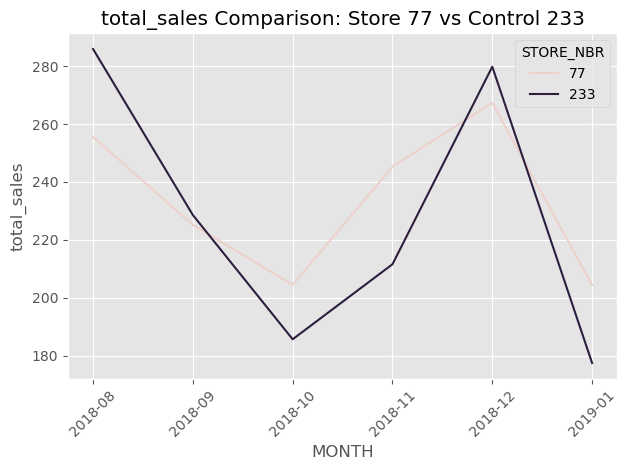

In [9]:
def plot_store_comparison(trial_store, control_store, metric):
    data = monthly_data[(monthly_data['STORE_NBR'].isin([trial_store, control_store])) &
                        (monthly_data['MONTH'].isin(pre_trial_period))]

    sns.lineplot(data=data, x='MONTH', y=metric, hue='STORE_NBR')
    plt.title(f'{metric} Comparison: Store {trial_store} vs Control {control_store}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_store_comparison(77, control_for_77, 'total_sales')

#### Compare Trial vs Control During Trial
Now calculate percentage difference or standardized score (z-score).

In [10]:
def compare_trial_vs_control(trial_store, control_store):
    trial_data = monthly_data[(monthly_data['STORE_NBR'] == trial_store) & 
                              (monthly_data['MONTH'].isin(trial_period))]

    control_data = monthly_data[(monthly_data['STORE_NBR'] == control_store) & 
                                (monthly_data['MONTH'].isin(trial_period))]

    compare = trial_data.merge(control_data, on='MONTH', suffixes=('_trial', '_control'))
    compare['sales_diff_pct'] = (compare['total_sales_trial'] - compare['total_sales_control']) / compare['total_sales_control'] * 100
    compare['cust_diff_pct'] = (compare['n_customers_trial'] - compare['n_customers_control']) / compare['n_customers_control'] * 100
    compare['txn_diff_pct'] = (compare['transactions_trial'] - compare['transactions_control']) / compare['transactions_control'] * 100
    return compare

compare_trial_vs_control(77, control_for_77)

,STORE_NBR_trial,MONTH,total_sales_trial,n_customers_trial,transactions_trial,avg_txn_per_cust_trial,STORE_NBR_control,total_sales_control,n_customers_control,transactions_control,avg_txn_per_cust_control,sales_diff_pct,cust_diff_pct,txn_diff_pct
0,77,2019-02,235.0,45,45,1.000000,233,244.0,45,47,1.044444,-3.688525,0.000000,-4.255319
1,77,2019-03,278.5,50,55,1.100000,233,199.1,40,41,1.025000,39.879458,25.000000,34.146341
2,77,2019-04,263.5,47,48,1.021277,233,158.6,30,32,1.066667,66.141236,56.666667,50.000000


#### Summarize Findings for Each Trial Store
Create a function to summarize and recommend.

In [11]:
def summarize_recommendation(trial_store, control_store):
    comparison = compare_trial_vs_control(trial_store, control_store)
    avg_sales_lift = comparison['sales_diff_pct'].mean()
    
    print(f"Store {trial_store} vs Control {control_store}")
    print(f"Avg Sales % Difference During Trial: {avg_sales_lift:.2f}%")

    if avg_sales_lift > 5:
        print("✅ Recommend Rollout")
    else:
        print("❌ Do Not Recommend Rollout")
    
    return comparison

summarize_recommendation(77, control_for_77)

Store 77 vs Control 233
Avg Sales % Difference During Trial: 34.11%
✅ Recommend Rollout


,STORE_NBR_trial,MONTH,total_sales_trial,n_customers_trial,transactions_trial,avg_txn_per_cust_trial,STORE_NBR_control,total_sales_control,n_customers_control,transactions_control,avg_txn_per_cust_control,sales_diff_pct,cust_diff_pct,txn_diff_pct
0,77,2019-02,235.0,45,45,1.000000,233,244.0,45,47,1.044444,-3.688525,0.000000,-4.255319
1,77,2019-03,278.5,50,55,1.100000,233,199.1,40,41,1.025000,39.879458,25.000000,34.146341
2,77,2019-04,263.5,47,48,1.021277,233,158.6,30,32,1.066667,66.141236,56.666667,50.000000


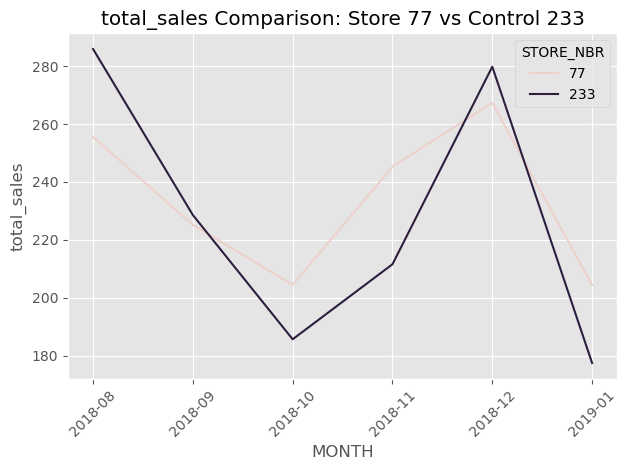

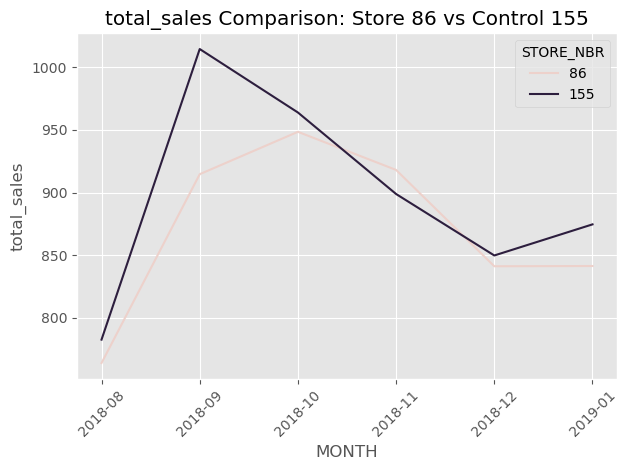

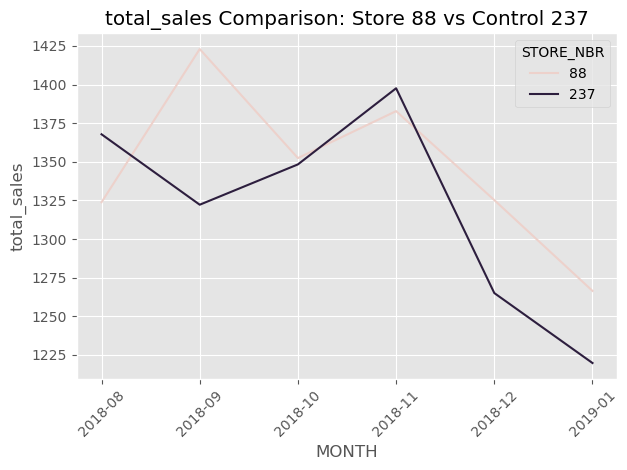

In [12]:
# Save plots or export as PDF
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("trial_analysis_plots.pdf")

for store, control in [(77, control_for_77), (86, control_for_86), (88, control_for_88)]:
    fig = plt.figure()
    plot_store_comparison(store, control, 'total_sales')
    pdf.savefig(fig)
    plt.close()

pdf.close()